# Assignment 6 - Reinforcement Learning

## *Eric Rios Soderman*
Netid: **ejr41**

*Names of students you worked with on this assignment*: **None**

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

## Learning objectives
After completing this assignment, you will be able to...
- Clearly articulate the role of the key components of reinforcement learning: the agent, actions, rewards, policies, state values, and action values.
- Apply policy evaluation to a problem in practice
- Use Monte Carlo control to determine and apply an optimal policy for a reinforcement learning problem and learn an optimal strategy from trial and error, alone

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack through trial-and-error learning. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1 (whichever is most advantageous to the player), and we're refer to it as a 'usable' Ace if we're treating it as 11 (indicating that it could be used as a '1', instead, if need be). This game is played with a deck of cards sampled with replacement.
- The game starts with both the player and the dealer having one face up and one face down card.
- The player can request additional cards (known as taking a "hit", which we define as action "1") until either they decide to stop (known as "staying", which we define as action '0') or their cards exceed 21 (known as a "bust", at which time the game ends and player loses).
- If the player stays (and hasn't exceeded a score of 21), the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer busts the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, tying is 0, and losing is -1.


Over the course of these exercises, you will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a naive policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [5 points] Human reinforcement learning 

Using the code detailed below, play at least 20 hands of the modified blackjack game below, and record your returns (average cumulative reward) across all episodes. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective. Since for this game, you only get a nonzero reward at the end of the episode, you can simply play the game and note the reward in a spreadsheet, then average across all plays of the game (of course, you're welcome to code up a way to do that automatically if you're so inspired).

In [60]:
import numpy as np



class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [61]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
s0 = game.deal()
print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
s1 = game.step(1)
print(s1)

# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

(18, 10, False)
((27, 10, False), -1, True)


### **ANSWER**

### **1(a) - Playing 20 Hands**

In [62]:
# Excited to do A6 : RL, let's go!	

# Wrapping the Blackjack game in a for loop

iter = 20
game_iter = np.array([])
game_reward = np.array([])

for i in range(1,iter+1):

    game = Blackjack()

    s0 = game.deal()

    s1 = game.step(1)

    special_counter = 0 

    # Indexing into the tuple's third value, 
    # which indicates whether the game is finished
    while not(s1[2]): 

        np.random.seed(special_counter) # Only for this Exercise 1
        s1 = game.step(np.random.choice([0,1]))
        special_counter += 1

    game_iter = np.append(game_iter, i)
    game_reward = np.append(game_reward, s1[1])

assert len(game_iter) == 20




In [63]:
print(f"My rewards for each episode are \n {game_reward}")

My rewards for each episode are 
 [-1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]


In [64]:
print(f"My average reward is {np.mean(game_reward)} after playing {len(game_iter)} games or hands.")

My average reward is -0.1 after playing 20 games or hands.


> ##### My rewards for each episode played were:  [ 1, -1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1, 1, -1].

> ##### My average reward was -0.1 after playing 20 hands. 

> ##### Conclusion : Blackjack is hard. 

## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing this modified version of blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots (sample code is provided below):
1. When you have a usable ace, plot the value function showing the dealer's card on the x-axis, and the player's sum on the y-axis, and use a colormap to plot the state value corresponding to each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Show the estimated state value function after 10,000 episodes.
2. Repeat (1) for the states without a usable ace (code is also provided for this).
3. Repeat (1) after 500,000 episodes.
4. Repeat (2) after 500,000 episodes.

**(b)** Show a plot of the cumulative average reward (returns) per episode vs the number of episodes. 
- For this plot, make the x-axis log scale
- For both the 10,000 episode case and the 500,000 episode case, state the final value of that average returns for this policy in those two cases (these are just the values of the plot of cumulative average reward at iteration 10,000 and 500,000, respectively), you can write this in a line of text. 

*Note on sample code: the code provided for these questions is meant to be a helpful starting point - you are not required to fill it out exactly or use all components, but it is meant to help you as you begin thinking about this problem.*

### **ANSWER**

### **2(a) - Code**

In [65]:
def policy_evaluation(N_episodes):
    # Initialize variables
    avg_return = np.array([])    # Accumulator to store the average returns over all episodes
    raw_return = np.array([])    # Accumulator to store the raw returns over all episodes
    episode_count = 0  # Number of episodes played (will increment as more episodes are played)
    N_player   = 32    # Number of possible states of the players hand
                       #  The max hand value is 21, but then if the player busts 
                       #  they could reach 32 (if they had 21 and took a hit)
    N_dealer   = 10    # Maximum number of states the dealer's hand could take on
                       #  1 through 10 (Ace could be 1 or 11, but would still be a singe card in hand)
    N_ace      = 2     # There are two states for the ace: (1) No usable ace, (2) Usable ace
    state_dict = {}    # Dictionary to record the rewards for each state
    # Initialize the state value function (in this case, the value function is the 
    #   average return over episodes, so no need for an explicit returns array)
    v = np.zeros((N_player, N_dealer, N_ace)) 
    
    # Initialize a variable counting the number of visits to each state
    n_visits = np.zeros((N_player, N_dealer, N_ace))
    
    # Initialize the policy that stays only if the player has 20 or 21, otherwise hit
    #######################
    # FILL IN THIS CODE
    def pi(s):
        """Return action for aggressive policy 
        Hit if the player sum is less than 20, otherwise stay
        """
        # print(f"The {s} state is being evaluated")
        if s[0] >= 20:
            return 0
        else:
            return 1
    #######################
    # Load the game
    B = Blackjack()
    
    # HELPER FUNCTIONS
    # Convert the current state into a set of indices for the value function
    def state_to_index(s):
        ace = 0
        if s[2]:
            ace = 1
        index = [s[0]-1, s[1]-1, ace]
        return index
    
    # Choose an action based on the policy, pi, and the current state, s
    def choose_action(pi,s):
        #######################
        # FILL IN THIS FUNCTION
        return pi(s)
        #######################
        # Outputs a value of 0 or 1
    
    # ----------------------------------------------------------------------
    # Run the policy evaluation   
    # ----------------------------------------------------------------------
    
    game_dict = {} # stores the states visited and the rewards for each episode

    for episode in range(N_episodes):
        
        # Deal a hand of blackjack
        initial_state = B.deal()
    
        # Initialize a variable to hold the list of states visited and add to 
        #  the list the initial state
        game_dict[episode] = {"states" : [initial_state], "rewards" : 0}
        
        # Play the hand through, following the policy

        new_state = B.step(choose_action(pi,initial_state))

        game_dict[episode]["states"].append(new_state[0])

        while not(new_state[2]):
            new_state = B.step(choose_action(pi,new_state[0]))
            game_dict[episode]["states"].append(new_state[0])
        
        reward = float(new_state[1])

        game_dict[episode]["rewards"] = reward
        
        # Update the average returns
        raw_return = np.append(raw_return, reward)
        avg_return = np.append(avg_return, np.mean(raw_return))

        # Update your state value function
        for state in game_dict[episode]["states"]:
            if str(state) in state_dict:
                state_dict[str(state)] += reward
            else:
                state_dict[str(state)] = reward
                
            index = state_to_index(state)
            n_visits[index[0], index[1], index[2]] += 1

            v[index[0], index[1], index[2]] = state_dict[str(state)]/n_visits[index[0], index[1], index[2]]
            

    return (v, avg_return)

In [66]:
# ---------------------------------------------------------------------------
# Sample plotting function for the state value function
# ---------------------------------------------------------------------------        

import matplotlib.pyplot as plt
# Uncomment the line below on macs for clearer plots:
# %config InlineBackend.figure_format = 'retina' 

# Plot the resulting state value function (expected returns from each state)
def plot_value(v):
    plt.figure(figsize=(10,7))
    drange = [1,10] # Dealer range
    prange = [4,21] # Player range
    axes = []
    axes.append(plt.subplot(1,2,1))
    plt.title('No Usable Ace')
    plt.imshow(v[prange[0]-1:prange[1],:,0], 
               vmin=-1,vmax=1,
               origin='lower', 
               extent=(drange[0]-0.5,
                       drange[1]+0.5,
                       prange[0]-0.5,
                       prange[1]+0.5),
               cmap = 'RdBu')
    plt.xticks(np.arange(drange[0],drange[1]+1,1))
    plt.yticks(np.arange(prange[0],prange[1]+1,1))
    plt.ylabel('Player Total')
    plt.xlabel('Dealer')
    
    axes.append(plt.subplot(1,2,2))
    plt.title('Usable Ace')
    im = plt.imshow(v[prange[0]-1:prange[1],:,1], 
               vmin=-1,vmax=1,
               origin='lower', 
               extent=(drange[0]-0.5,
                       drange[1]+0.5,
                       prange[0]-0.5,
                       prange[1]+0.5),
               cmap = 'RdBu')
    plt.xticks(np.arange(drange[0],drange[1]+1,1))
    plt.yticks(np.arange(prange[0],prange[1]+1,1))
    plt.ylabel('Player Total')
    plt.xlabel('Dealer')
    cbar = plt.colorbar(im, ax=axes)
    cbar.set_label('Value (Expected Returns)')

### **2(a) - Plots**

**2(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots (sample code is provided below):

1. When you have a usable ace, plot the value function showing the dealer's card on the x-axis, and the player's sum on the y-axis, and use a colormap to plot the state value corresponding to each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Show the estimated state value function after 10,000 episodes.
2. Repeat (1) for the states without a usable ace (code is also provided for this).
3. Repeat (1) after 500,000 episodes.
4. Repeat (2) after 500,000 episodes.

The policy evaluation methods have already been defined, and now the plots will be created.

In [67]:
two_a_10K,two_a_10K_avg_returns = policy_evaluation(10000)

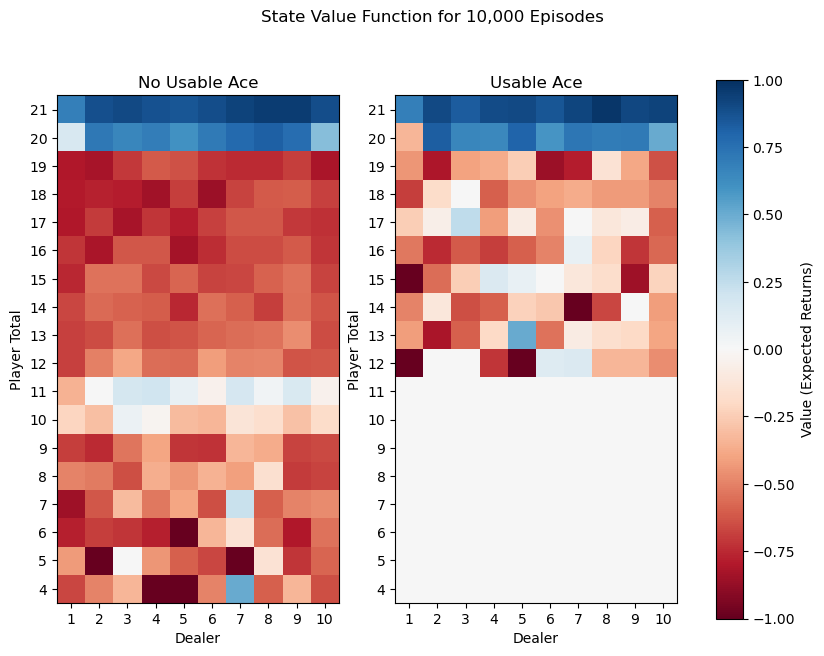

In [68]:
# Plot the state value function after 10,000 episodes
plot_value(two_a_10K)
plt.suptitle("State Value Function for 10,000 Episodes")
plt.show()

In [69]:
two_a_500K,two_a_500K_avg_returns = policy_evaluation(500000)

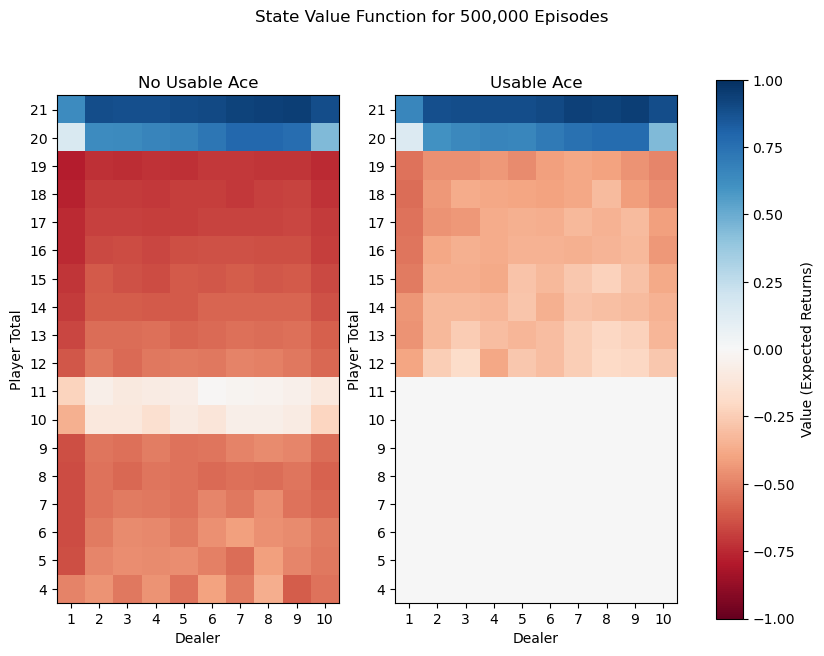

In [70]:
# Plot the state value function after 500,000 episodes
plot_value(two_a_500K)
plt.suptitle("State Value Function for 500,000 Episodes")
plt.show()

### **2(b)**


**2(b)** Show a plot of the cumulative average reward (returns) per episode vs the number of episodes. 
- For this plot, make the x-axis log scale
- For both the 10,000 episode case and the 500,000 episode case, state the final value of that average returns for this policy in those two cases (these are just the values of the plot of cumulative average reward at iteration 10,000 and 500,000, respectively), you can write this in a line of text. 

*Note on sample code: the code provided for these questions is meant to be a helpful starting point - you are not required to fill it out exactly or use all components, but it is meant to help you as you begin thinking about this problem.*

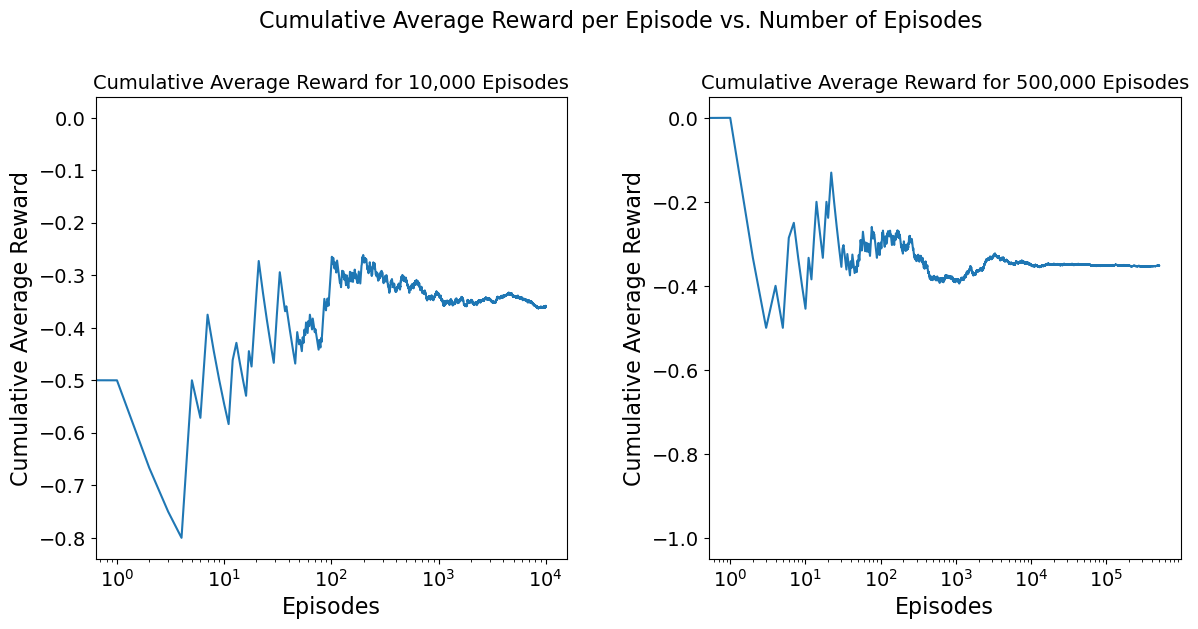

In [71]:
# plotting the cumulative average reward
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(two_a_10K_avg_returns)
ax1.set_title("Cumulative Average Reward for 10,000 Episodes", size=14)
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Cumulative Average Reward")
ax1.set_xscale('log')

ax2.plot(two_a_500K_avg_returns)
ax2.set_title("Cumulative Average Reward for 500,000 Episodes", size=14)
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Cumulative Average Reward")
ax2.set_xscale('log')

plt.suptitle("Cumulative Average Reward per Episode vs. Number of Episodes", size=16, y=1.025)

# increase font size
for ax in fig.axes:
    ax.tick_params(labelsize=14)

# increase font of y labels
for ax in fig.axes:
    ax.yaxis.label.set_size(16)
    ax.xaxis.label.set_size(16)

# increase spacing between subplots
plt.subplots_adjust(wspace=0.3)

plt.show()


In [72]:
# Showing the final cumulative average reward for each number of episodes
print(f"The final, cumulative average return for 10,000 episodes is {two_a_10K_avg_returns[-1]}.")
print(f"The final, cumulative average return for 500,000 episodes is {two_a_500K_avg_returns[-1]:.4f}.")

The final, cumulative average return for 10,000 episodes is -0.3583.
The final, cumulative average return for 500,000 episodes is -0.3521.


> #### The final value of the cumulative average returns for 10,000 episodes is -0.3583, and the final value of the cumulative average returns for 500,000 episodes is roughly -0.3521. 

## 3

### [40 points] Perform Monte Carlo Control

Now it's time to actually implement a reinforcement learning strategy that learns to play this version of Blackjack well, only through trial-and-error learning. Here, you will develop your Monte Carlo Control algorithm and evaluate its performance for our Blackjack-like game.

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the state value function and the action value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed. Varying $0 \leq N_0 < \inf$ will determine the amount of exploration the algorithm performs where the lower $N_0$ the less exploration and vice versa.

Show your results by plotting the optimal state value function: $v^*(s) = \max_a q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the 2018 edition (5.5 in the original edition) - sample code provided for the plots. Your results SHOULD be very similar to the plots in that text (although you will show your results with the player sum ranging from 2 to 21). For these plots include the following (note - code from the previous section of this assignment for state value function plotting and below for policy plotting are provided to help you to accomplish these):
1. When you have a useable ace, plot the value function with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the colormap and `imshow` to plot the value function that corresponds with those states. Plot the state value corresponding to each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the same states but without a usable ace.
3. Plot the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot can be an imshow plot with binary values - sample code provided).
4. Plot the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot can be an imshow plot with binary values - sample code provided).


**(b)** Plot the cumulative average return per episode vs the number of episodes (your x-axis should be log-scaled to clearly see the trend). What is the average return your control strategy was able to achieve? You'll know your method is working if you see a steady rise in your average returns over time.

*Note on convergence: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

*Note on sample code: the code provided for these questions is meant to be a helpful starting point - you are not required to fill it out exactly or use all components, but it is meant to help you as you begin thinking about this problem.*

### **ANSWER**

### **3(a) - Code**

In [73]:
import array as arr

def mc_control(
    episodes,
    eps_val=100,
    checkpoint=False,
    save_counter=5000000,
    checkpoint_v=None,
    checkpoint_pi=None,
    checkpoint_avg_return=None,
    checkpoint_N=None,
    checkpoint_nv_visits=None,
    checkpoint_nq_visits=None,
):
    """
    This function implements the Monte Carlo Control algorithm.
    A few checkpoint arguments have been added to save the arrays representing
    the state value function, v, and the policy, pi, at a certain episode.
    In addition, the optimized argument has been added to allow for the use of
    the optimized version of the algorithm, which drops the append method
    needed for the cumulative average returns, as it is computationally expensive.
    It returns the state value function, v, and the policy, pi, that were learned.
    """
    N_player = 32
    N_dealer = 10
    N_ace = 2
    N_actions = 2

    avg_return = arr.array(
        "d", []
    )  # Array for storing the average return for each episode
    N = 0  # This N is the number of episodes completed so far
    N0 = eps_val  # Coefficient for controlling the level of exploration
    counter_N = save_counter  # Counter for knowing when to save the arrays
    last_counter_N0 = 0  # Variable for storing the episodes required to
    # trigger the saving of the arrays

    # Initialize the state value function, v, and the action value function, q
    v = np.zeros((N_player, N_dealer, N_ace))
    q = np.zeros((N_player, N_dealer, N_ace, N_actions))

    # Initialize a variable counting the number of visits to each state
    nv_visits = np.zeros((N_player, N_dealer, N_ace))  # For the state value function
    nq_visits = np.zeros(
        (N_player, N_dealer, N_ace, N_actions)
    )  # For the action value function

    # Initialize the policy to all always "stay" (all zeros)
    pi = np.zeros((N_player, N_dealer, N_ace))

    

    if checkpoint:
        N = checkpoint_N
        v = np.load(checkpoint_v)
        pi = np.load(checkpoint_pi)
        avg_return = checkpoint_avg_return
        nv_visits = np.load(checkpoint_nv_visits)
        nq_visits = np.load(checkpoint_nq_visits)
        episode_file_to_write = f"ep_count_runtime_optimized_CP{N}.txt"

    # Initialize the game
    B = Blackjack()

    # HELPER FUNCTIONS
    # Convert the current state into a set of indices for the state value function
    def state_to_index_v(s):
        ace = 0
        if s[2]:
            ace = 1
        index = [s[0] - 1, s[1] - 1, ace]
        return index

    # Convert the current state into a set of indices for the action value function
    def state_to_index_av(s, a):
        ace = 0
        if s[2]:
            ace = 1
        index = [s[0] - 1, s[1] - 1, ace, int(a)]
        return index

    # Choose an action based on the policy, pi, and the current state, s, with
    #  epsilon-greedy exploration
    def choose_action(pi, s):
        #######################
        # FILL IN THIS FUNCTION
        #######################
        # Outputs an action
        """Return an action for the given state
        This implementation uses epsilon-greedy exploration
        """

        state_index = state_to_index_v(s)
        number_of_visits = nv_visits[state_index[0], state_index[1], state_index[2]]
        epsilon = N0 / (N0 + number_of_visits)
        probability = np.random.random()
        if probability < epsilon:  # Exploration
            action = np.random.choice([0, 1])

        else:  # Exploitation
            action = pi[state_index[0], state_index[1], state_index[2]]

        return int(action)

    # ----------------------------------------------------------------------
    # Run episodes of MC Control
    # ----------------------------------------------------------------------
    for episode in range(episodes):
        # Play a hand a blackjack
        initial_state = B.deal()

        # Record the initial state

        chosen_action = choose_action(pi, initial_state)

        game_dict = {
            "state_action_pairs": [(initial_state, chosen_action)],
            "reward": 0,
        }

        new_state = B.step(chosen_action)

        # Play out the hand

        while not (new_state[2]):
            new_action = choose_action(pi, new_state[0])
            game_dict["state_action_pairs"].append((new_state[0], new_action))

            new_state = B.step(new_action)

        # Record the reward for the episode
        reward = new_state[1]
        game_dict["reward"] = reward

        # Update average return count
        last_counter_N0 += 1
        N += 1

        if N == 1:
            new_average = reward
            avg_return.extend([new_average])

        else:
            new_average = (reward / N) + ((N - 1) / N) * avg_return[-1]

            avg_return.extend([new_average])

        for state_action_pair in game_dict["state_action_pairs"]:
            # Obtaining the state and action indices
            state = state_action_pair[0]
            action = state_action_pair[1]
            state_index = state_to_index_v(state)
            state_action_index = state_to_index_av(state, action)

            # Updating the state value functions
            nv_visits[state_index[0], state_index[1], state_index[2]] += 1

            avg_value_at_state = v[state_index[0], state_index[1], state_index[2]]

            n_visits_to_state = nv_visits[
                state_index[0], state_index[1], state_index[2]
            ]

            # assign online running average to the state
            v[state_index[0], state_index[1], state_index[2]] = (
                reward / n_visits_to_state
            ) + ((n_visits_to_state - 1) / n_visits_to_state) * avg_value_at_state

            # Updating the action value functions
            nq_visits[
                state_action_index[0],
                state_action_index[1],
                state_action_index[2],
                state_action_index[3],
            ] += 1

            avg_value_at_action_state = q[
                state_action_index[0],
                state_action_index[1],
                state_action_index[2],
                state_action_index[3],
            ]

            n_visits_to_action_state = nq_visits[
                state_action_index[0],
                state_action_index[1],
                state_action_index[2],
                state_action_index[3],
            ]

            # assign online running average to the action at the state

            q[
                state_action_index[0],
                state_action_index[1],
                state_action_index[2],
                state_action_index[3],
            ] = (reward / n_visits_to_action_state) + (
                (n_visits_to_action_state - 1) / n_visits_to_action_state
            ) * avg_value_at_action_state

            # Updating the policy
            pi[state_index[0], state_index[1], state_index[2]] = np.argmax(
                q[state_index[0], state_index[1], state_index[2], :]
            )

        if last_counter_N0 == counter_N:
            last_counter_N0 = 0
            np.save(f"v_{str(N)}.npy", v)
            np.save(f"pi_{str(N)}.npy", pi)
            np.save(f"avg_return_{str(N)}.npy", avg_return)
            np.save(f"v_visits_{str(N)}.npy", nv_visits)
            np.save(f"q_visits_{str(N)}.npy", nq_visits)
            np.save(f"q_{str(N)}.npy", q)

            episode_file_to_write = "ep_count_runtime_optimized().txt"

            with open(episode_file_to_write.replace("()", str(N)), "w") as file:
                file.write(
                    f"Episode {str(episode)} completed, avg_return : {avg_return}\n"
                )

    return (v, pi, avg_return)

In [74]:
#-------------------------------------------------
# Sample code for plotting your policy
#-------------------------------------------------
def plot_policy(pi):
    # Plot the policy
    drange = [1,10]
    prange = [4,21]
    plt.figure(figsize=(10,7))
    axes = []
    axes.append(plt.subplot(1,2,1))
    plt.title('No Usable Ace')
    plt.imshow(pi[prange[0]-1:prange[1],:,0], 
               vmin=0,vmax=1,
               origin='lower', 
               extent=(drange[0]-0.5,
                       drange[1]+0.5,
                       prange[0]-0.5,
                       prange[1]+0.5),
               cmap = 'binary_r')
    plt.xticks(np.arange(drange[0],drange[1]+1,1))
    plt.yticks(np.arange(prange[0],prange[1]+1,1))
    plt.ylabel('Player Total')
    plt.xlabel('Dealer')
    
    axes.append(plt.subplot(1,2,2))
    plt.title('Usable Ace')
    im = plt.imshow(pi[prange[0]-1:prange[1],:,1], 
               vmin=0,vmax=1,
               origin='lower', 
               extent=(drange[0]-0.5,
                       drange[1]+0.5,
                       prange[0]-0.5,
                       prange[1]+0.5),
               cmap = 'binary_r')
    plt.xticks(np.arange(drange[0],drange[1]+1,1))
    plt.yticks(np.arange(prange[0],prange[1]+1,1))
    plt.ylabel('Player Total')
    plt.xlabel('Dealer')
    cbar = plt.colorbar(im, ax=axes)
    cbar.set_label('Action (Stay = 0, Hit = 1)')

### **3(a) - Plots**

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the state value function and the action value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed. Varying $0 \leq N_0 < \inf$ will determine the amount of exploration the algorithm performs where the lower $N_0$ the less exploration and vice versa.

Show your results by plotting the optimal state value function: $v^*(s) = \max_a q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the 2018 edition (5.5 in the original edition) - sample code provided for the plots. Your results SHOULD be very similar to the plots in that text (although you will show your results with the player sum ranging from 2 to 21). For these plots include the following (note - code from the previous section of this assignment for state value function plotting and below for policy plotting are provided to help you to accomplish these):
1. When you have a useable ace, plot the value function with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the colormap and `imshow` to plot the value function that corresponds with those states. Plot the state value corresponding to each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the same states but without a usable ace.
3. Plot the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot can be an imshow plot with binary values - sample code provided).
4. Plot the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot can be an imshow plot with binary values - sample code provided).


In [75]:
mc_v_5_million, mc_pi_5_million, mc_avg_return_5_million = mc_control(5000000)

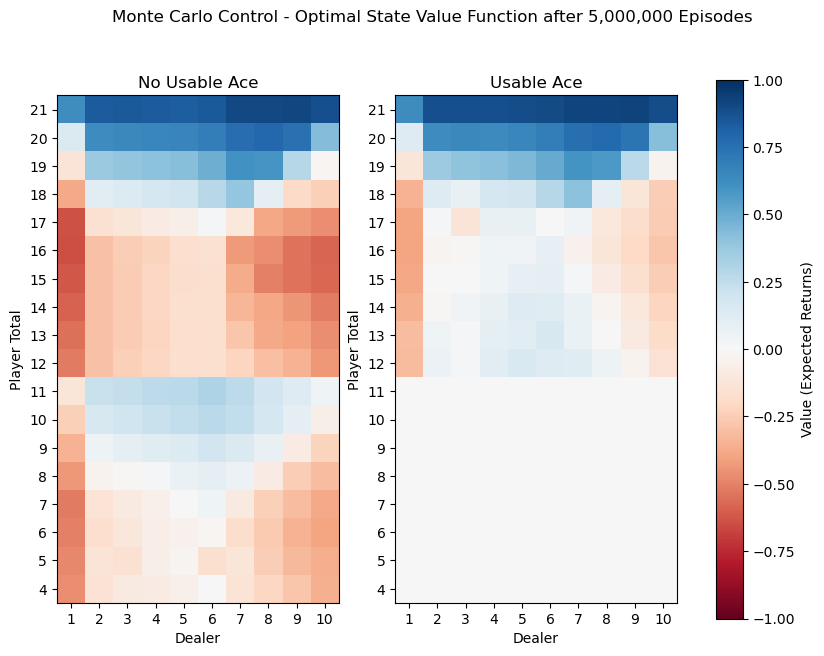

In [76]:
plot_value(mc_v_5_million)
plt.suptitle("Monte Carlo Control - Optimal State Value Function after 5,000,000 Episodes")
plt.show()

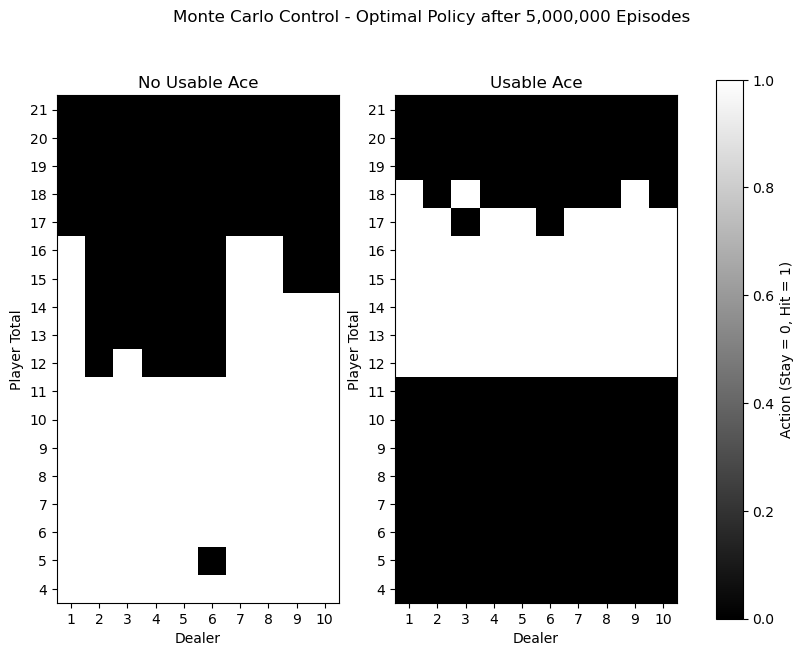

In [77]:
plot_policy(mc_pi_5_million)
plt.suptitle("Monte Carlo Control - Optimal Policy after 5,000,000 Episodes")
plt.show()

In [78]:
mc_v_50_million, mc_pi_50_million, mc_avg_return_50_million = mc_control(50000000,eps_val=1000)

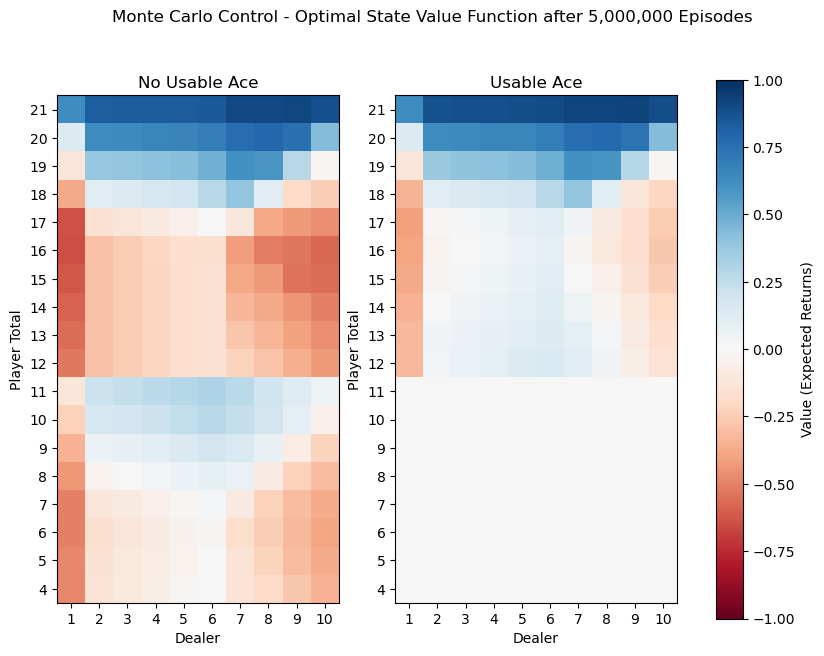

In [79]:
plot_value(mc_v_50_million)
plt.suptitle("Monte Carlo Control - Optimal State Value Function after 5,000,000 Episodes")
plt.show()

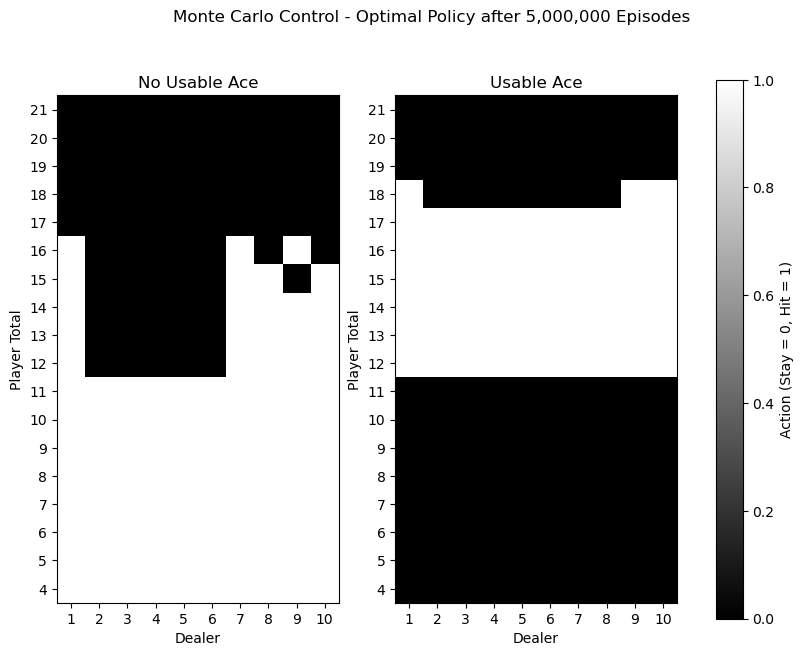

In [80]:
plot_policy(mc_pi_50_million)
plt.suptitle("Monte Carlo Control - Optimal Policy after 5,000,000 Episodes")
plt.show()

In [81]:
mc_v_100_million, mc_pi_100_million, mc_avg_return_100_million = mc_control(100000000,eps_val=10000)

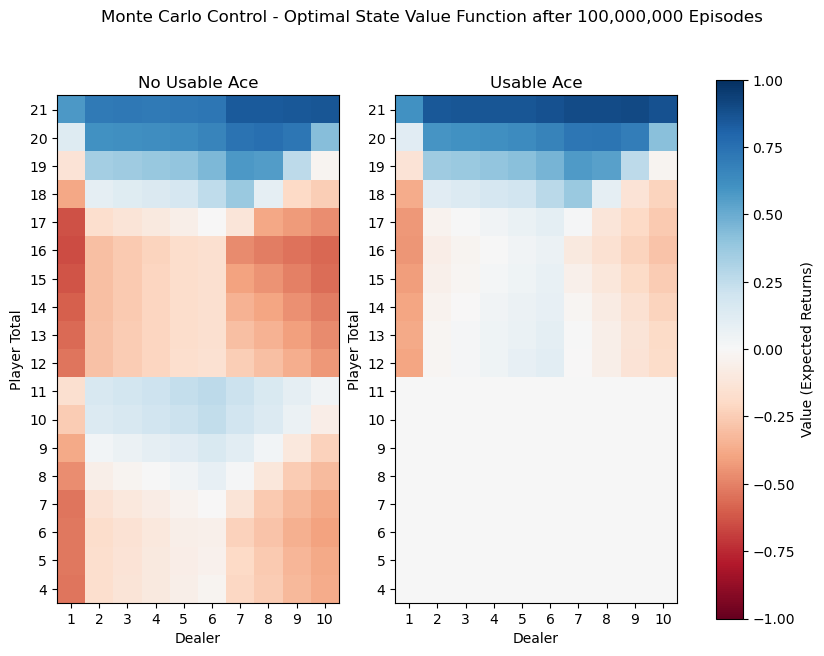

In [82]:
plot_value(mc_v_100_million)
plt.suptitle("Monte Carlo Control - Optimal State Value Function after 100,000,000 Episodes")
plt.show()

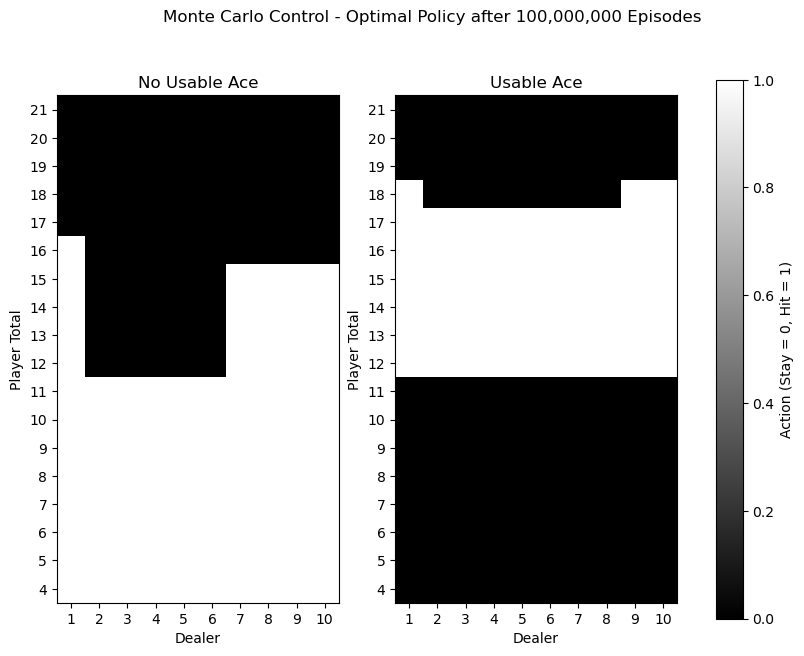

In [83]:
plot_policy(mc_pi_100_million)
plt.suptitle("Monte Carlo Control - Optimal Policy after 100,000,000 Episodes")
plt.show()

In [84]:
# memory constraints limited this run to 900 million episodes instead of 1 billion
mc_v_900_million, mc_pi_900_million, mc_avg_return_900_million = mc_control(900000000,eps_val=1000000, save_counter=100000000)

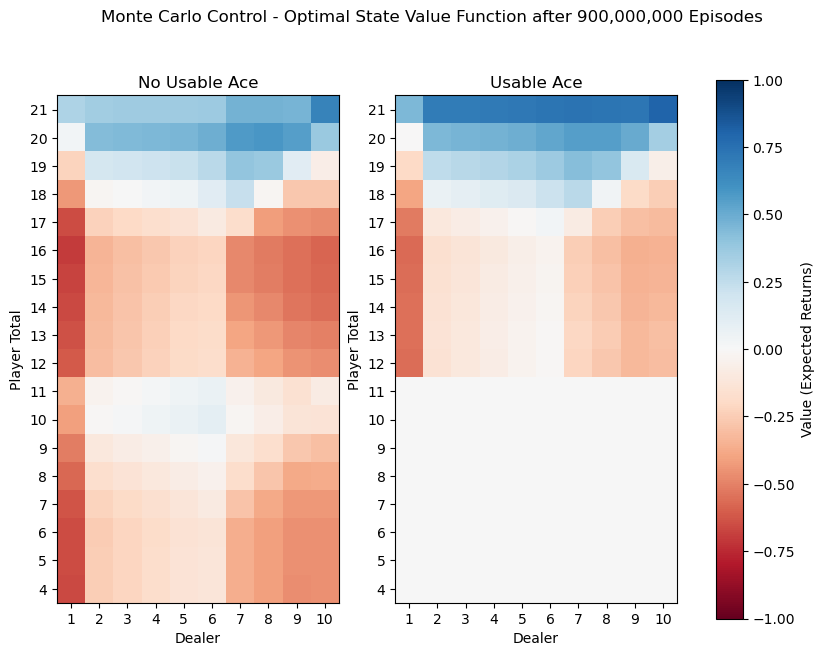

In [85]:
plot_value(mc_v_900_million)
plt.suptitle("Monte Carlo Control - Optimal State Value Function after 900,000,000 Episodes")
plt.show()

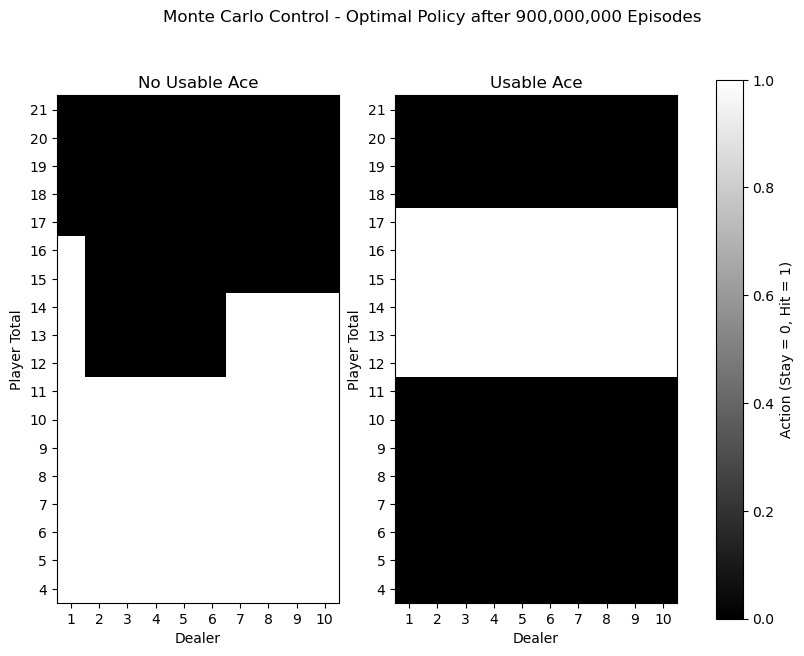

In [86]:
plot_policy(mc_pi_900_million)
plt.suptitle("Monte Carlo Control - Optimal Policy after 900,000,000 Episodes")
plt.show()

In [87]:
mc_v_500_million, mc_pi_500_million, mc_avg_return_500_million = mc_control(500000000,eps_val=100000, save_counter=100000000)

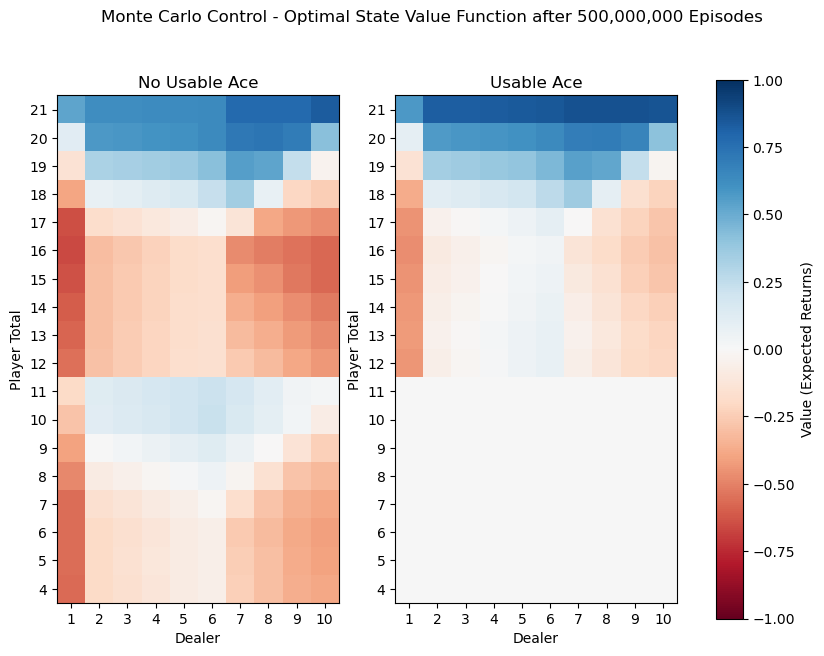

In [88]:
plot_value(mc_v_500_million)
plt.suptitle("Monte Carlo Control - Optimal State Value Function after 500,000,000 Episodes")
plt.show()

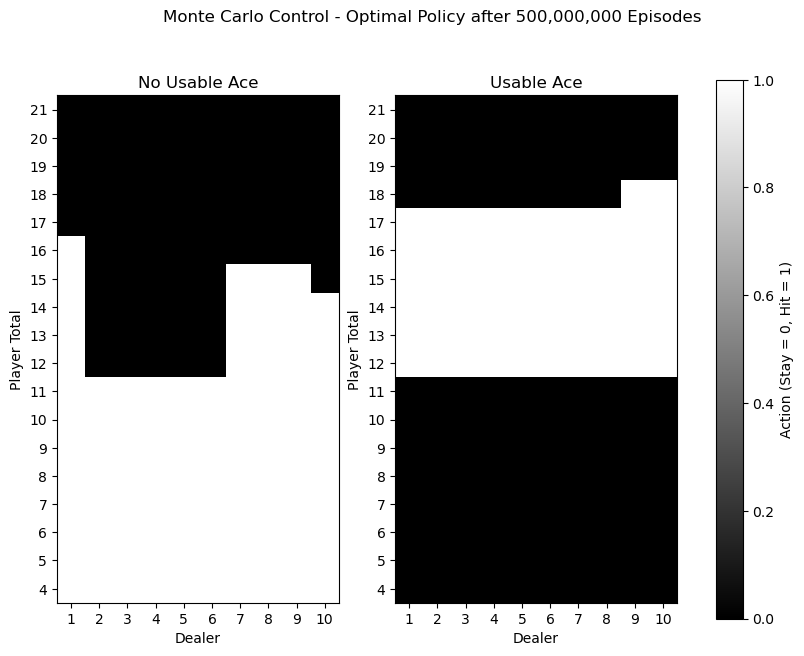

In [89]:
plot_policy(mc_pi_500_million)
plt.suptitle("Monte Carlo Control - Optimal Policy after 500,000,000 Episodes")
plt.show()

#### **3(b)**


**(b)** Plot the cumulative average return per episode vs the number of episodes (your x-axis should be log-scaled to clearly see the trend). What is the average return your control strategy was able to achieve? You'll know your method is working if you see a steady rise in your average returns over time.

*Note on convergence: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

*Note on sample code: the code provided for these questions is meant to be a helpful starting point - you are not required to fill it out exactly or use all components, but it is meant to help you as you begin thinking about this problem.*

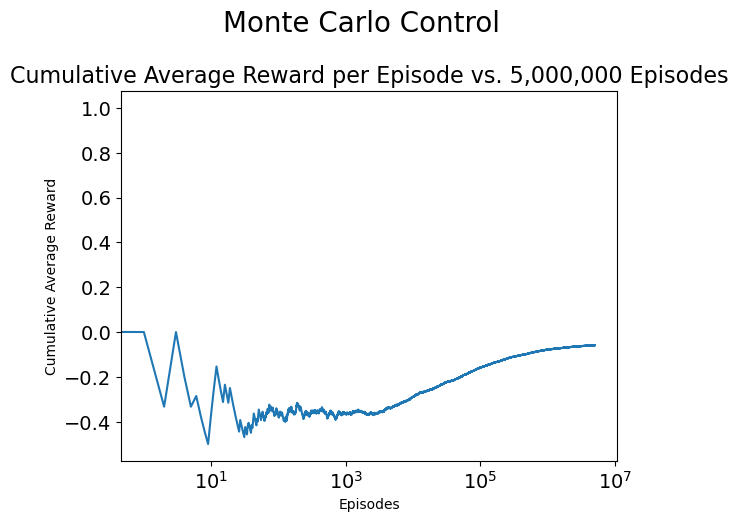

In [90]:
plt.plot(mc_avg_return_5_million)
plt.title("Cumulative Average Reward per Episode vs. 5,000,000 Episodes", fontsize=16)
plt.suptitle("Monte Carlo Control", fontsize=20, y=1.05)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Average Reward")
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks(fontsize=14)
plt.show()

In [91]:
print(f"The cumulative average return for 5,000,000 episodes is {mc_avg_return_5_million[-1]:.4f}.")

The cumulative average return for 5,000,000 episodes is -0.0591.


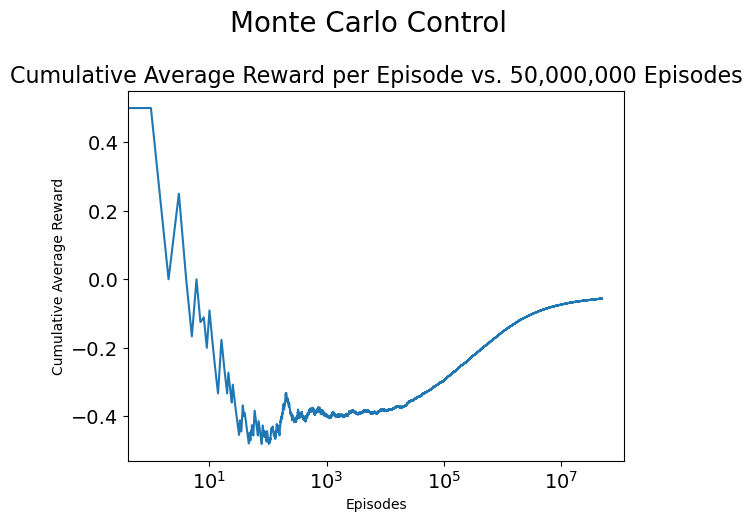

In [92]:
plt.plot(mc_avg_return_50_million)
plt.title("Cumulative Average Reward per Episode vs. 50,000,000 Episodes", fontsize=16)
plt.suptitle("Monte Carlo Control", fontsize=20, y=1.05)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Average Reward")
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks(fontsize=14)
plt.show()

In [93]:
print(f"The cumulative average return for 50,000,000 episodes is {mc_avg_return_50_million[-1]:.4f}.")

The cumulative average return for 50,000,000 episodes is -0.0565.


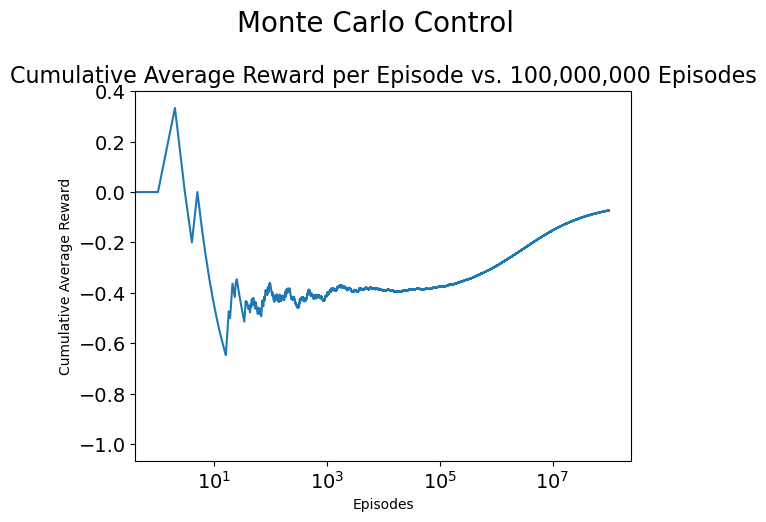

In [94]:
plt.plot(mc_avg_return_100_million)
plt.title("Cumulative Average Reward per Episode vs. 100,000,000 Episodes", fontsize=16)
plt.suptitle("Monte Carlo Control", fontsize=20, y=1.05)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Average Reward")
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks(fontsize=14)
plt.show()

In [95]:
print(f"The cumulative average return for 100,000,000 episodes is {mc_avg_return_100_million[-1]:.4f}.")

The cumulative average return for 100,000,000 episodes is -0.0731.


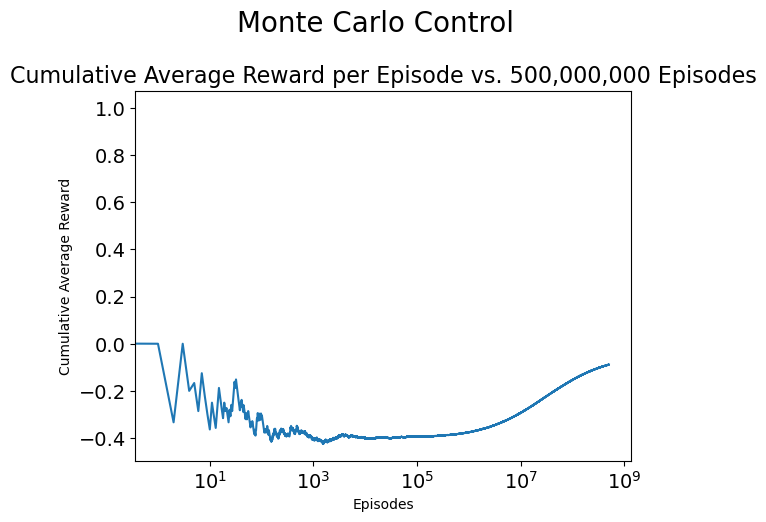

In [96]:
plt.plot(mc_avg_return_500_million)
plt.title("Cumulative Average Reward per Episode vs. 500,000,000 Episodes", fontsize=16)
plt.suptitle("Monte Carlo Control", fontsize=20, y=1.05)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Average Reward")
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks(fontsize=14)
plt.show()

In [97]:
print(f"The cumulative average return for 500,000,000 episodes is {mc_avg_return_500_million[-1]:.4f}.")

The cumulative average return for 500,000,000 episodes is -0.0885.


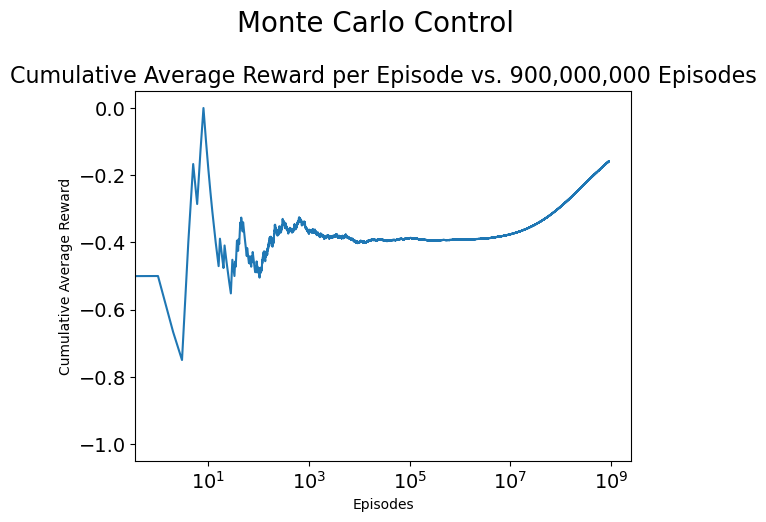

In [98]:
plt.plot(mc_avg_return_900_million)
plt.title("Cumulative Average Reward per Episode vs. 900,000,000 Episodes", fontsize=16)
plt.suptitle("Monte Carlo Control", fontsize=20, y=1.05)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Average Reward")
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks(fontsize=14)
plt.show()

In [99]:
print(f"The cumulative average return for 900,000,000 episodes is {mc_avg_return_900_million[-1]:.4f}.")

The cumulative average return for 900,000,000 episodes is -0.1584.


# 4

## [5 points] Discuss your findings

Compare the performance of your human control policy, in question 1, the naive policy from question 2, and the optimal control policy in question 3. 

**(a)** Which performs best? What was different about the policies developed for each and how may that have contributed to their comparative advantages?

**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not? *(assume the policy estimated from your MC control algorithm had **fully converged**)*

### **ANSWER**

#### **4(a)**

Compare the performance of your human control policy, in question 1, the naive policy from question 2, and the optimal control policy in question 3. 

**(a)** Which performs best? What was different about the policies developed for each and how may that have contributed to their comparative advantages?


> #### As for the human control policy, it was a random guess policy where I chose to hit or stay randomly, and it was wrapped under a for loop. In the context of this modified Blackjack, where one is trying to beat this virtual dealer, random guessing isn't a good policy for choosing actions. However, the true highlight of random guessing is to highlight the importance of exploration, where the agent (in this case a loop and a random guess representing my own actions) is choosing to hit or stay randomly. As I see the guesses play out in realtime, I am able to comprehend the impact of the usable and non-usable aces, as well as how staying causes the dealer to draw and potentially win or bust and how maybe I can hit until I get lucky into approximating a sum of 21 or bust as well. Regardless, placing the benefits of human exploration aside, it is the least effective policy because the agent representing myself is not doing anything to learn about the states in which it is placed and neither which actions to take. In short, it has no tactical advantage over the other two policies.

> #### For the naive policy, it adopted a completely different and aggressive approach. The policy was either only stay when the player sum was 20 or 21; if the card sum was anything but those two numbers, the agent would choose to hit otherwise. This means that if the player sum was 1, 10, 13 or even 19, the agent would hit and draw a card. By examining the value function table, it is easier to conclude that this policy was obviously smarter than a random guess. Additionally, there are many noteworthy aspects to this policy. The obvious case is that the expected rewards are positive for the agent at player sums of 20 and 21, as they should be, given that the policy dictates staying when reaching those states. Also, usable aces allow the player sum to scale high or low in order to simultaneously avoid a bust and secure a win. For this reason, the states with usable aces are a lighter shade of red, but do not quite break even due to the aggressive policy (having to hit unless 20 or 21 is reached). In other words, it is easier to reach wins or minimize losses from these states, which explains the better expected returns at those states.

> #### On the other hand, one can notice that, when the player sum is high but below 20, from 12 to 19, the expected returns of those states are shades of a darker red that are indicating a negative value of very low rewards. This intuitively carries a lot of sense because drawing any card when one has 19 as a total sum will likely cause a bust and a loss in the game. Likewise, drawing a card of 10 points when the sum is 12 will put the total at 22, causing another bust. In addition, drawing a 4 at, for example, a state of a sum of 13, puts the new sum at 17, but the agent will hit again because 20 or 21 has not been reached, and a bust will likely happen (if the agent drew any card higher than a 4). 



> #### There is a very nuanced point underlying this, which took me a few runs to understand. This deck has replacement, and all cards are replenished upon being drawn; however, the deck composition is the same. There 4 card types of each value : spades, diamonds, clubs and hearts, and there are 52 cards in a deck. More importantly, the Queen, Jack, and King are worth 10 each, and there is also an additional card with the value of 10 as well. Since these 4 cards have 4 types each, that means that 16 cards of a 52 card deck are worth 10 points. Therefore, the agent has a 16/52 or a 1/13 probability of drawing one of these cards. Drawing any of those 16 cards when the player sum is 12 will immediately cause a bust. Like another example above, if the agent starts with a total sum of 5, then draws to raise the sum to 9 and draws a 10, for a grand total of 19. Because of the aggressive policy, the agent will hit again and likely bust. Due to this nuanced point, conversely, it is for this exact reason that the states of 11 and 10 are so advantageous to the agent's policy. If drawing one of the 16 aforementioned 10 point cards, if the agent has a current sum of 10, the agent's total sum will now rise to 20, and then the agent will stay and likely win the game because the dealer will eventually bust. The same logic holds for the state of 11, where it is even more fortuitous to draw a 10 point card of these 16, given that the maximum score for victory is 21. As such, being in states 11 and 10 is where the agent's policy is most effective. This is the main takeaway; this policy optimized for certain states. What if there was a policy that outperformed this aggressive policy and the human policy by having better state values than them? This policy capped at an cumulative average reward of -0.3523, so a policy to usurp this one will likely attain a better cumulative average reward.

> #### Apologies for the extensive answer, but the conclusion arrives here with Monte Carlo Control. Through trial and error, at each episode, the expected returns of the states and the actions associated with those states were updated only when two conditions were met. The state had to be visited within that episode, and the action had to be taken (or visited as well) for that specific state. Once these the running averages (or updates) for the state and action values were completed, the policy itself was updated immediately after at the end of each episode, and the policy is deterministic at heart. It will choose the action, stay or hit, for a given state that has the highest expected associated reward. That's it. The magic behind the policy iteration and evaluation process lies in the use of epsilon-greedy exploration. Epsilon is a value against which a randomly generated probability is compared against. If the probability is greater, the action for a given state will be taken according to the deterministic policy. If epsilon is greater, the action to be taken from a given state will be randomly chosen. This is called the balance between exploitation (deterministic policy) and exploration (epsilon or random choosing). When there are little visits to the state (and the probability is not expected to beat the epsilon value), the agent will likely explore and generate very accurate estimates of the action values. As a state is more often visited, likely after the agent has explored a bit, the epsilon value will be a bit lower, and the random probability generated may be higher than epsilon. At this point, the agent has transitioned from exploring less and exploiting more. This interplay between exploration and exploitation, but especially exploration since it allows to better estimate values for the action space because it isn't deterministic in its choices, is what allows the policy update to be so effective. When following the policy, the agent will choose the action that will yield the highest expected rewards, and the ballpark estimates for these actions were obtained through exploration, and they were narrowed down even further to exploitation, almost as if the algorithm encouraged the agent to invest in the action that always keeps winning. Lastly, this approach's effectiveness is validated via the state value plot, where the states are slowly becoming more blue (postive rewards) over time, likely as a result of choosing the deterministically choosing actions that will yield the most reward (after having learned the right actions to take via exploring). Eventually the state value plot will change to a mostly blue coloring, indicative of the improving rewards. In addition, the optimal policy is defined as mostly hitting when below 12 for the player sum without a usable ace and staying for the player sum above 12 without a usable ace. With usable aces, the optimal policy shows that hitting is the preferred choice unless the player sum is above 17, in which case the agent would stay. To close this extensive answer, the cumulative average reward for this resulting policy, which was articulated with an epsilon greedy approach, is -0.0566, which conclusively depicts this final policy as the optimal policy, given that it has maximized the cumulative average reward over its counterparts and directly implies that the state values that it were estimated were equal or better than its counterpart policies' estimates as well.

#### **4(b)**

**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not? *(assume the policy estimated from your MC control algorithm had **fully converged**)*

> #### A full Markov Decision Process implies that all the possible states, the transitional probabilities, the possible actions, and the rewards are known. The only things unknown to the agent are the transitional probabilities of reaching states S' from a given state S if action A was taken. As for the question, would knowing the full MDP, in this case knowing the transitional probabilities between states, have led to creating a better policy? The answer is "Yes, but the MC control fully converged already, and it is good enough for the task."


> #### First, context will be given to the fully known MDP and its corresponding dynamic programming approach. The fully known MDP and our current MC control problem share knowledge of the action space and the possible states. What is not shared is the transition model and the reward knowledge. For the latter, the agent under the MC control algorithm does not know how well it executed until the episode is over. The transitional probabilities are not know in our MC control problem, and we don't have a fully known MDP in that specific problem. In an MDP, the transitional probabilities give information that the agent can use to navigate the environment, to define the optimal policy. In other words best illustrated by an example, the objective in this Blackjack game is to reach 20 or 21 and beat the dealer. Therefore, the desired S' is 21 to give the best possibilities of beating the dealer. If the agent has a card sum of 18 in its hand, it now has to decide whether to stay or hit. Before making a decision, the agent consults the transition probabilities. If choosing to hit, there is a 0.01 probability of ending up at 21, 0.1 for 19, 0.5 for 23, 0.3 for 28, and so on and so forth. The agent is trying to maximize the reward, so, by consulting the roadmap of the state transitions, it will realize that it can't maximize the reward that much by hitting because the hit (action) will lead it to an S that leads to a negative reward and not the S' that leads it to a positive reward. In this case, the agent will likely stay. Likewise, if the sum is 10 for the agent's hand, then there may be a 0.4 probability reaching state 20 by hitting. Hitting may net a higher reward than staying, so the agent will choose to hit. To recapitulate, the transitional probabilities aid the agent in choosing the actions that lead to the best possible states and eventual highest rewards. It is essential to developing the optimal policy, and converging upon this policy is likely to be faster and more straightforward. Also, because it is deterministic outright, it will likely incur in having higher values for the actions and states than the optimal policy generated by the MC control strategy. Why? Simple, it is due to the fact that MC control requires exploration, and exploration will lead to undesirable states and actions that will incur in negative rewards. In other words, MC's exploration will involve more "screwing up" than the dynamic programming approach of the fully known MDP. This exploration will naturally lead to lower expected returns for the states and actions, even if the MC control had fully converged. 



> #### This last idea is also best illustrated by an example. With MC control and epsilon-greedy approach, the agent visited a state with a card sum of 19 a total of 1 million times. 800,000 of those times, it choose the actions that netted it a negative and/or neutral reward. For the remaining 200,000, it chose the actions that led to positive rewards. This ratio, for the dynamic programming with a fully known MDP, might look like the inverse, 200,000 choices of either stay or hit that led to ties or negative rewards and maybe 800,000 wins or positive rewards...because the agent made use of the transitional probabilities to guide its choice of staying or hitting, likely opting for staying most of the time. Because the dynamic programming approach led to a policy that minimized negative rewards and maximized positive rewards as much as possible, which also propagated to the states and actions having better expected returns, the dynamic programming approach led to a better overall policy than the optimal policy generated by MC control.

> #### Now, the context will be given to MC. Unlike the dynamic programming in a fully known MDP, the MC control algorithm doesn't know all the information. It has states, actions, doesn't know the rewards until the episode is complete, and knows no transitional probabilities (in this particular example). However, similar to dynamic programming, the objective is to generate an optimal policy that will lead to the maximize the returns across all states. The key similarity here is that both approaches, with the information available at their disposal, are seeking to figure out the best actions to take at a given state. In the context of MC control, since the agent doesn't know which actions or states are opportune, it has to balance the act of exploiting and exploring. It will eventually "screw up" or make unfavoreable choices to know which actions are the best and worst ones to take. As such, even though the values of the states will be lowered due to the initial exploration, the agent will still be learning the optimal way to navigate the environment, learning the policy. Here comes the special part : convergence. Eventually, the monte control algorithm's epsilon will fade into obscurity. States will have been visited so many times that the randomly generated probability of making an action will be higher than epsilon, where the exploitation will be higher than the exploration. The optimal policy has already been defined due to the countless episodes of trial and error, and the agent will naturally converge unto choosing deterministically the action at any given state that best maximizes the reward. In simpler terms, it has visited state 19 enough times and updated its policy enough times to the point that it will consistently opt to stay, and, at this point the value of the state will begin to increase until it levels out or converges somewhat later, when the value is no longer changing.

> #### Now, the final takeaway will be connected. Although a fully known MDP with dynamic programming will generate better values for the states, at the end of the day, both MC control and dynamic programming helped define optimal policies, and these policies are very likely the same. If the agent has a card sum of 19, when following both of the algorithms' optimal policies, the agent will stay. If the agent has a sum of 3, under both policies, the agent will hit. These algorithms are both means to an end, and this end is defined as how to best navigate an environment to maximize the rewards. Both provide the overall, same optimal insight into how to navigate the environment, and this navigation consists of the actions to take at the possible states. In practice, we rarely have access to the full MDP (the transitional probabilities especially), so the MC control algorithm is more than an excellent substitute for the agent to learn what the optimal policy is for all state space of a problem.  